**Fitting a reward model offline**

In this example, we'll train a vanilla PPO agent on the Brax Ant environment using the "ground truth" reward provided by the environment. We'll then fit a reward model to the resulting clips.

In order to do this, we'll need to "record" a subset of the environment states visited by the agent during the training process. For this we can use the `BraxRecorder` environment wrapper class, which uses JAX host callbacks to efficiently record these states without interrupting Brax's wicked fast all-GPU training loop.

In [ ]:
from brax.envs import create_fn
from brax.training import ppo
from classroom.brax import BraxRecorder
import numpy as np

train_sps = []

def progress(_, metrics):
    train_sps.append(metrics['speed/sps'])

def env_fn(name: str, db_path: str):
    brax_fn = create_fn(env_name=name)
    return lambda *args, **kwargs: BraxRecorder(brax_fn(*args, **kwargs), db_path)


ppo.train(
    environment_fn=env_fn('ant', '~/classroom/ant'), num_timesteps = 30_000_000,
    log_frequency = 10, reward_scaling = .1, episode_length = 1000,
    normalize_observations = True, action_repeat = 1, unroll_length = 5,
    num_minibatches = 32, num_update_epochs = 4, discounting = 0.97,
    learning_rate = 3e-4, entropy_cost = 1e-2, num_envs = 2048,
    batch_size = 1024, progress_fn = progress
)

print(f'train steps/sec: {np.mean(train_sps[1:])}')

If you like, you can now use the Classroom GUI to input your own preferences on the resulting clips. For this example, though, we'll simulate the human preference feedback by stochastically generating preferences based on the ground truth rewards. `SyntheticPairwisePrefs` samples the preference for each pair of clips from a mixture distribution with two components:
- a distribution based on the [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model) of pairwise comparison, where the probability of preferring A to B is equal to the sigmoid of the difference in "scores" of A and B, and
- a uniform distribution over the two clips, representing the possibility of the human making a "mistake" and selecting a clip at random.

The "scores" for the Bradley-Terry distribution are the rescaled sums of rewards for each clip. `SyntheticPairwisePrefs` normalizes the rewards to zero mean and unit variance, then scales them by a "rationality" parameter β which defaults to 5.0. You can also choose the weight assigned to the mistake distribution with the `mistake_prob` parameter; by default it is set to 0.1.

Note that the total number of pairwise comparisons in any dataset scales quadratically with the dataset size, which could easily get unwieldy with even medium-size datasets. Training a model on all `N(N - 1) // 2` pairs of clips could also lead to overfitting since the model will see each clip many times per epoch. To prevent this, `SyntheticPairwisePrefs` samples a subset of `N` clip pairs _without replacement_ by shuffling the dataset and creating pairs from adjacent clips in the shuffled dataset. The random seed used to sample clip pairs and preferences can be set using the `seed` parameter and defaults to 0.

In [56]:
from classroom.datasets import SyntheticPairwisePrefs, SyntheticListwisePrefs
import jax.numpy as jnp
import numpy as np


ds = SyntheticPairwisePrefs(
    '/home/nora/value-learning/ant/seed_0',
    # batch_size=64,
    # mistake_prob=0.01,
    transform=lambda x: np.concatenate([x.state.obs, x.action], axis=-1)
)

In [57]:
from classroom.datasets import BatchedDataset, SubsetDataset
import numpy as np

indices = np.random.permutation(len(ds))
test_size = round(len(ds) * 0.2)

test = SubsetDataset(ds, indices[:test_size])
# val = SubsetDataset(ds, indices[test_size:test_size * 2])
# train = SubsetDataset(ds, indices[test_size * 2:])
val = BatchedDataset(SubsetDataset(ds, indices[test_size:test_size * 2]), 64)
train = BatchedDataset(SubsetDataset(ds, indices[test_size * 2:]), 64)

We recommend implementing your preference model as a subclass of `classroom.jax.PairwisePrefModel` if possible, since this base class implements most of the training loop boilerplate code for you.

In [58]:
from classroom.jax import ListwisePrefModel, PairwisePrefModel
import flax.linen as nn
import jax.numpy as jnp


class MlpPrefModel(PairwisePrefModel):
    hidden_layers: list[int]

    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        for size in self.hidden_layers:
            x = nn.Dense(size)(x)
            x = nn.activation.relu(x)
            # x = nn.Dropout(0.1)(x, deterministic=eval)
        
        # scores, var = RandomFeatureGaussianProcess(1)(x)
        scores = nn.Dense(1)(x)
        return jnp.mean(scores.squeeze(-1), axis=-1)

Training the model is as simple as calling `model.fit()` with your training and validation datasets.

In [59]:
model = MlpPrefModel([32, 16])
state = model.fit(train, val)

Epoch 1 train loss: 0.659 val accuracy: 0.856 val loss: 0.613
Epoch 2 train loss: 0.576 val accuracy: 0.863 val loss: 0.533
Epoch 3 train loss: 0.499 val accuracy: 0.866 val loss: 0.455
Epoch 4 train loss: 0.433 val accuracy: 0.866 val loss: 0.393
Epoch 5 train loss: 0.390 val accuracy: 0.872 val loss: 0.353
Epoch 6 train loss: 0.370 val accuracy: 0.878 val loss: 0.333
Epoch 7 train loss: 0.363 val accuracy: 0.875 val loss: 0.323
Epoch 8 train loss: 0.360 val accuracy: 0.875 val loss: 0.319
Epoch 9 train loss: 0.358 val accuracy: 0.875 val loss: 0.316
Epoch 10 train loss: 0.357 val accuracy: 0.875 val loss: 0.314
Epoch 11 train loss: 0.355 val accuracy: 0.875 val loss: 0.313
Epoch 12 train loss: 0.354 val accuracy: 0.872 val loss: 0.311
Epoch 13 train loss: 0.352 val accuracy: 0.878 val loss: 0.310
Epoch 14 train loss: 0.351 val accuracy: 0.881 val loss: 0.309
Epoch 15 train loss: 0.350 val accuracy: 0.881 val loss: 0.308
Epoch 16 train loss: 0.349 val accuracy: 0.884 val loss: 0.307
E

In [52]:
model.apply({'params': state.params}, test, method=model.test)

{'kendalltau': 0.6655142748467353, 'loss': 2.486251}

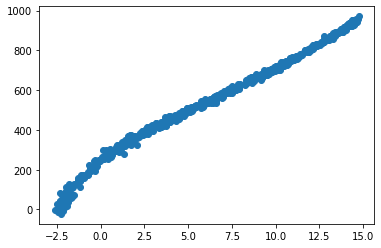

In [102]:
import matplotlib.pyplot as plt

plt.scatter(
    np.concatenate(rank_corr.scores, axis=0),
    np.concatenate(rank_corr.labels, axis=0),
)